# 3. Model tests
## 3.02 Example: Linear Regression Model

In [1]:
import sys
sys.path.append("../../")
print(sys.executable)
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import dask
dask.config.set(scheduler='threads')
import xarray as xr

import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

from sklearn.linear_model import LinearRegression

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/bin/python3


Note that the functions defined in this notebook can be found in the `python.aux.utils_floodmodel` or `python.aux.plot` file and will be loaded from those in the following notebooks.

## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data.

The features are already prepared and ready to use, hence why they can be loaded directly from the `features_xy.nc` file.

Let's open the files and see what's in there:

In [2]:
# load data
features = xr.open_dataset('../../data/features_xy.nc')
y = features['dis']
X = features.drop(['dis', 'dis_diff'])

In [3]:
features

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    lsp-4-11    (time) float32 ...
    lsp-12-25   (time) float32 ...
    lsp-26-55   (time) float32 ...
    lsp-56-180  (time) float32 ...
    lsp-1       (time) float32 ...
    lsp-2       (time) float32 ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...
    dis         (time) float64 ...
    dis_diff    (time) float64 ...

Some control parameters for the procedure:

 * `add_shift_switch`: Shift and add shifted values as new features for multi-day forecasts. (only needed if forecasting multiple days at once => currently only implemented with nns!)
 * `dis_shift_1`: Add the discharge from the last day as additional feature for testing purposes.
 * `abs_vals_switch`: Model is trained on absolute discharge values if True and on differences/change in discharge else.

In [4]:
dis_shift_switch = False

In [5]:
abs_vals_switch = False

Begin with some short preprocessing..

In [6]:
if dis_shift_switch:
    dis_shift_1 = y.shift(time=1)
    X = X.assign({'dis-1': dis_shift_1})

In [7]:
X_base = X.to_array(dim='features').T.copy()
y_base = y.copy()

Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [8]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))

In [9]:
X_train, y_train = X_base.loc[period_train], y_base.loc[period_train]
X_valid, y_valid = X_base.loc[period_valid], y_base.loc[period_valid]
X_test, y_test = X_base.loc[period_test], y_base.loc[period_test]

In [10]:
X_train.shape, y_train.shape

((9131, 16), (9131,))

In [11]:
def remove_outlier(x):
    """Removes outliers under, over 1th, 99th percentile of the input pandas series.
    
    Parameters
    ----------
        x : pd.Series
    """
    x99 = x.quantile(0.99)
    x01 = x.quantile(0.01)
    x = x.where(x > x01).dropna()
    x = x.where(x < x99).dropna()
    return x

In [12]:
Xda = X_train.chunk(dict(time=-1, features=-1)).dropna(dim='time').to_pandas()

if abs_vals_switch:
    # train on absolute values
    yda = y_train.to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]
else:
    # train on change in discharge values
    yda = y_train.diff(dim='time').to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]

# Define LinearRegressionModel

In [13]:
Xda.values.shape, yda.values.shape

((8742, 16), (8742,))

In [14]:
model = LinearRegression(n_jobs=-1)

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', model),], verbose=True)

In [15]:
x_fit = Xda.values.copy()
y_fit = yda.values.copy()
pipe.fit(x_fit, y_fit)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1,
                                  normalize=False))],
         verbose=True)

### in sample test for the predicted change, to verify functionality

In [16]:
def add_time(vector, time, name=None):
    """Converts input vector to xarray.DataArray with the corresponding input time coordinate.
    
    Parameters
    ----------
        vector : numpy.array
        time   : xr.DataArray
        name   : str
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

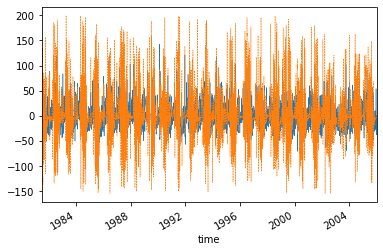

In [17]:
Xda_insample = Xda.copy()
insample_check = pipe.predict(Xda_insample.values)
insample_check = add_time(insample_check, Xda_insample.index, name='forecast')
insample_check.to_pandas().plot(linewidth=0.5)
yda.plot(linestyle='--', linewidth=0.5)

Set the frequency at which forecast are started.

In [18]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_valid[::n].copy()
y_pred = pipe.predict(X_pred.values)
y_pred = add_time(y_pred, X_pred.time, name='forecast')
print(y_pred)

<xarray.DataArray 'forecast' (time: 2191)>
array([  8.379528, -11.274258,   4.556293, ..., -33.152084, -49.85989 ,
       -24.327524], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2011-12-31


In [19]:
def generate_prediction_array(y_pred, y_truth, forecast_range=14):
    """Convenience function to generate a [number of forecasts, forecast range] shaped xr.DataArray from the one
    dimensional xr.DataArray input prediction and converts the predicted discharge change into absolute values,
    starting from t=t0 with the reanalysis value for each forecast.
    
    Parameters
    ----------
        y_pred          : xr.DataArray
        y_truth         : xr.DataArray
        forecast_range  : int
    """
    # reorganize data into the shape [forecast_range, number_of_forecasts]
    # add +1 to forecast range to include the init state in the length
    num_forecasts = int(np.floor(y_pred.shape[0]/(forecast_range+1)))
    full_forecast_len = num_forecasts*(forecast_range+1)
    new_pred = y_pred[:full_forecast_len].copy()
    time_new = y_pred.time[:full_forecast_len].copy()
    time_new_data = time_new.values.reshape([num_forecasts, (forecast_range+1)])
    pred_multif_data = new_pred.values.reshape([num_forecasts, (forecast_range+1)])
    # set init to reanalysis value
    pred_multif_data[:,0] = y_truth.where(new_pred)[0::(forecast_range+1)].values
    # cumulative sum to accumulate the forecasted change
    pred_multif_data_fin = np.cumsum(pred_multif_data, axis=1)
    
    pred_multif = xr.DataArray(pred_multif_data_fin,
                               coords={'num_of_forecast': range(1, num_forecasts+1),
                                       'forecast_day': range(0, forecast_range+1),
                                       'time': (('num_of_forecast', 'forecast_day'), time_new_data)},
                               dims=['num_of_forecast', 'forecast_day'],
                              name = 'prediction')
    return pred_multif

In [20]:
multif = generate_prediction_array(y_pred, y, forecast_range=14)

In [21]:
def plot_multif_prediction(pred_multif, y_truth, forecast_range=14, title=None):
    """Convenience function for plotting multiforecast shaped prediction and truth.
    
    Parameters
    ----------
        pred_multif     : xr.DataArray
        y_truth         : xr.DataArray
        forecast_range  : int
        title           : str
    """
    fig, ax = plt.subplots(figsize=(15,5))
    y_truth.sel({'time': pred_multif.time.values.ravel()}).to_pandas().plot(ax=ax, label='reanalysis')

    pdseries = pd.Series(data=pred_multif.sel(num_of_forecast=1).values,
                         index=pred_multif.sel(num_of_forecast=1).time.values)
    pdseries.plot(ax=ax, label='forecast')
    plt.legend()
    for i in pred_multif.num_of_forecast[1:]:
        fcst = pd.Series(data=pred_multif.sel(num_of_forecast=i).values,
                             index=pred_multif.sel(num_of_forecast=i).time.values)
        fcst.plot(ax=ax)

    ax.set_ylabel('river discharge [m$^3$/s]')
        
    y_o = y_truth.loc[{'time': pred_multif.time.values.ravel()}].values
    y_m = pred_multif.values.ravel()

    rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
    nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))

    plt.title(f"{title} | RMSE={round(float(rmse), 2)}; NSE={round(float(nse), 2)} |")
    return fig, ax

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8c48046128>)

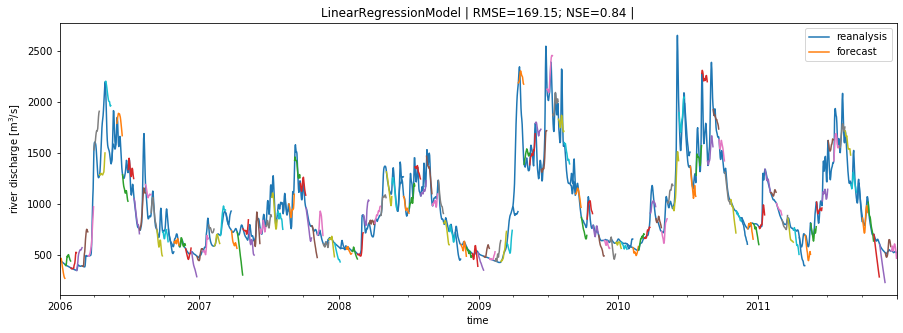

In [22]:
plot_multif_prediction(multif, y, forecast_range=14, title='LinearRegressionModel')

#### Check the skill of a 14-day persistence forecast:

In [23]:
forecast_range = 14
y_o_pers = y_valid
# persistence
y_m_pers = y_valid.copy()
for i in range(1, forecast_range):
    y_m_pers.loc[y_valid.time[i::forecast_range]] = y_valid.shift(time=i)[i::forecast_range].values
    
rmse = np.sqrt(np.nanmean((y_m_pers - y_o_pers)**2))
nse = 1 - np.sum((y_m_pers - y_o_pers)**2)/(np.sum((y_o_pers - np.nanmean(y_o_pers))**2))
print(f"Persistence {forecast_range}-day forecast: RMSE={round(float(rmse), 2)}; NSE={round(float(nse.values), 2)}")

Persistence 14-day forecast: RMSE=210.1; NSE=0.75


|   varying param     |   RMSE   |   NSE   | 
| :--------: | :-----: | :-----: | 
| LinearRegressionModel | 203.08 | 0.86 |
| --------------- | --------------- | --------------- |
| persistence 14-day forecast  | 251.09 | 0.77 |


Note that for the standard OLS Linear Regression Model, there are no Hyperparameters to optimize.

Concluding, even though the Linear Regression Model is very simple, it captures a lot of the development parts correctly and is better than the 14-day persistence forecast (which is the absolute minimum threshold a model has to reach, else it would have no skill and be worthless).

## Prediction for the test data (used in the model evaluation notebook for comparison)

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8c141ffac8>)

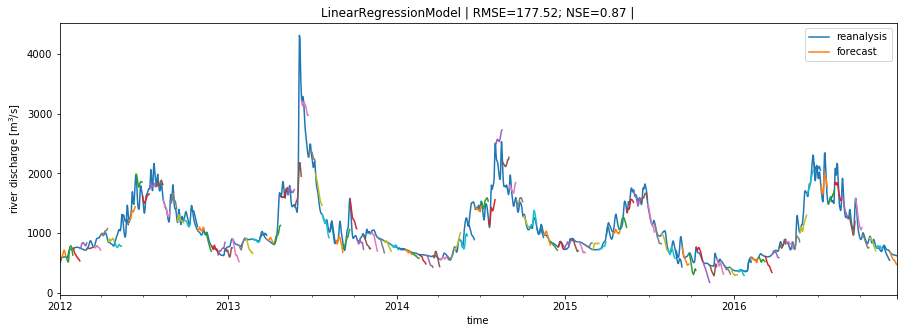

In [24]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_test[::n].copy()
y_pred = pipe.predict(X_pred.values)
y_pred = add_time(y_pred, X_pred.time, name='forecast')

multif_test = generate_prediction_array(y_pred, y, forecast_range=14)
plot_multif_prediction(multif_test, y, forecast_range=14, title='LinearRegressionModel')

## Case study: May/June 2013; Flooding event at Krems (Danube river)

In [25]:
def multi_forecast_case_study(pipe_case, x, y):
    """
    Convenienve function for predicting discharge via the pre-trained input pipe. Loads glofas forecast_rerun
    data from a in-function set path, used to evaluate the model predictions.
    Outputs are 3 xr.DataArrays: One for the model forecast, one for the forecast reruns, one for the reanalysis.
    
    Parameters
    ----------
        pipe_case : trained ML pipe ready for prediction
        x         : xr.DataArray
        y         : xr.DataArray
    """
    y_2013 = y
    X_2013 = x
    
    multif_list = []
    multifrerun_list = []
    for forecast in range(1, 5):
        if forecast == 1:
            date_init = '2013-05-18'
            date_end = '2013-06-17'
            fr_dir = '2013051800'
        elif forecast == 2:
            date_init = '2013-05-22'
            date_end = '2013-06-21'
            fr_dir = '2013052200'
        elif forecast == 3:
            date_init = '2013-05-25'
            date_end = '2013-06-24'
            fr_dir = '2013052500'
        elif forecast == 4:
            date_init = '2013-05-29'
            date_end = '2013-06-28'
            fr_dir = '2013052900'
        
        X_case = X_2013.sel(time=slice(date_init, date_end)).copy()
        y_case = y_2013.sel(time=slice(date_init, date_end)).copy()
        
        # prediction start from every nth day
        # if in doubt, leave n = 1 !!!
        n = 1
        X_pred = X_case[::n].copy()
        y_pred = pipe_case.predict(X_pred.values)
        y_pred = add_time(y_pred, X_pred.time, name='forecast')
        
        multif_case = generate_prediction_array(y_pred, y_2013, forecast_range=30)
        multif_case.num_of_forecast.values = [forecast]
        multif_list.append(multif_case)
        
        # add glofas forecast rerun data
        # glofas forecast rerun data
        frerun = xr.open_mfdataset(f'../../data/glofas-freruns/{fr_dir}/glof*', combine='by_coords')
        poi = dict(lat=48.35, lon=13.95)
        fr = frerun['dis'].sel(lon=slice(13, 14), lat=slice(49, 48)).compute()
        fr = fr.where(~np.isnan(fr), 0).interp(poi).drop(labels=['lat', 'lon']).squeeze()
        multifrerun_list.append(fr)
    
    # merge forecasts into one big array
    date_init = '2013-05-18'
    date_end = '2013-06-28'
    y_case_fin = y_2013.sel(time=slice(date_init, date_end)).copy()
    X_case_multi_core = X_2013.sel(time=slice(date_init, date_end)).isel(features=1).copy().drop('features')*np.nan
    
    X_list = []
    for fc in multif_list:
        X_iter = X_case_multi_core.copy()
        X_iter.loc[{'time': fc.time.values.ravel()}] = fc.values[0]
        X_list.append(X_iter)
    X_multif_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multif_fin.name='prediction'
    
    X_list = []
    for frr in multifrerun_list:
        X_iter = X_case_multi_core.copy()
        ens_list = []
        for fr_num in frr.ensemble:
            fr_iter = frr.sel(ensemble=fr_num)
            X_ens_iter = X_iter.copy()
            X_ens_iter.loc[{'time': frr.time.values}] = fr_iter.values
            ens_list.append(X_ens_iter)
        ens_da = xr.concat(ens_list, dim='ensemble')
        X_list.append(ens_da)
    X_multifr_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multifr_fin.name='forecast rerun'
    return X_multif_fin, X_multifr_fin, y_case_fin

In [26]:
X_multif_fin, X_multifr_fin, y_case_fin = multi_forecast_case_study(pipe, X_test, y)

Text(0.5, 1.0, 'LinearRegressionModel case study May/June 2013 |\xa0ML_forecast: solid |\xa0glofas forecast_reruns: dashed\ninit: 18.05.-green; 22.05.-cyan; 25.05.-magenta; 29.05.-black')

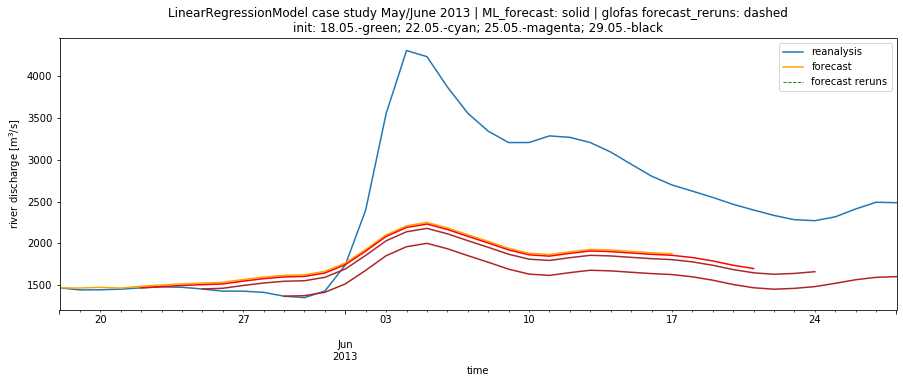

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
color_scheme = [['orange', 'r', 'brown', 'firebrick'],
               ['g', 'cyan', 'magenta', 'k']]

y_case_fin.to_pandas().plot(ax=ax, label='reanalysis')
run = 0
for i in X_multifr_fin.num_of_forecast:
    X_multif_fin.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='forecast', color=color_scheme[0][run])
    X_multifr_fin.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='frerun', linewidth=0.9,
                                                            linestyle='--', color=color_scheme[1][run])
    run += 1
ax.set_ylabel('river discharge [m$^3$/s]')
plt.legend(['reanalysis', 'forecast', 'forecast reruns'])
plt.title('LinearRegressionModel case study May/June 2013 | ML_forecast: solid | glofas forecast_reruns: dashed\ninit: 18.05.-green; 22.05.-cyan; 25.05.-magenta; 29.05.-black')

Save the postprocessed model forecast, as well as the forecast rerun and the reanalysis data.

In [28]:
X_multif_fin.to_netcdf('../../data/models/LinearRegression/linear_regression_result_case_study.nc')
X_multifr_fin.to_netcdf('../../data/glofas_freruns_case_study.nc')
y_case_fin.to_netcdf('../../data/glofas_reanalysis_case_study.nc')

Save data of the test period for the model comparison.

In [29]:
multif_test.to_netcdf('../../data/models/LinearRegression/linear_regression_result_test_period.nc')
y_test = y.sel({'time': multif_test.time.values.ravel()}).copy()
y_test.to_netcdf('../../data/glofas_reanalysis_test_period.nc')